In [ ]:
# Installing dependencies
!pip install dendropy biopython
!pip install torch-scatter==latest+cu101 torch-sparse==latest+cu101 -f https://s3.eu-central-1.amazonaws.com/pytorch-geometric.com/whl/torch-1.4.0.html
!pip install torch-geometric

     |████████████████████████████████| 15.2MB 200kB/s 
     |████████████████████████████████| 2.3MB 53.6MB/s 
  Created wheel for dendropy: filename=DendroPy-4.4.0-cp36-none-any.whl size=442139 sha256=f412590507f5c636118d10659144b41892555cd8170b355a69d868f68fb3bac0
  Stored in directory: /root/.cache/pip/wheels/88/76/d0/90381494189528abc27fab0faa25bf960143460963daae7ba7
Successfully built dendropy
Looking in links: https://s3.eu-central-1.amazonaws.com/pytorch-geometric.com/whl/torch-1.4.0.html
     |████████████████████████████████| 10.6MB 7.4MB/s 
     |████████████████████████████████| 15.2MB 52.4MB/s 
     |████████████████████████████████| 133kB 8.1MB/s 
     |████████████████████████████████| 348kB 15.9MB/s 
     |████████████████████████████████| 51kB 7.9MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-1.4.3-cp36-none-any.whl size=234873 sha256=36c940f50c4780bc8d763499a46b2c32b487960069681b4eabeb0ae86461afa3
  Stored in directory: /root/.cache/pip/wheels/e2/

In [ ]:
# mount data
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
!ls /content/gdrive/My\ Drive/data

Archaea  Fungi30  Metazoa15  Metazoa30	     processed	       Proteobacteria45
Fungi15  Fungi45  Metazoa25  OtherEukaryota  Proteobacteria30


In [ ]:
import torch
import dendropy
from Bio import SeqIO
from dendropy.calculate.treecompare import symmetric_difference
from torch_geometric.data import InMemoryDataset, Data


class MAGraph(InMemoryDataset):
    """A dataset class containing trees and aligned sequences as nodes' features"""
    def __init__(self, root, trees, etalon_tree, alignments, seq_to_tensor, tensor_length=64, transform=None,
                 pre_transform=None):
        """"
        self.trees = trees
        self.etalon = etalon_tree
        self.alignments = alignments
        self.att = seq_to_tensor
        self.feat_length = tensor_length
        super().__init__(root, transform, pre_transform)
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return self.trees + self.alignments

    @property
    def processed_file_names(self):
        return ['data.pt']

    def download(self):
        pass

    def process(self):
        data_list = list()
        taxa = dendropy.TaxonNamespace()
        etalon_tree = dendropy.Tree.get(
            path=self.etalon,
            schema='newick',
            taxon_namespace=taxa,
        )
        tree_yielder = dendropy.Tree.yield_from_files(
            files=self.trees,
            schema='newick',
            taxon_namespace=taxa,
        )
        for tree, aln_file in zip(tree_yielder, self.alignments):
            # reading tree
            # reading alignment
            with open(aln_file) as fin:
                seq_dict = {seq.name: seq.seq for seq in SeqIO.parse(fin, 'fasta')}
            # create tensors
            nlen = len(tree.nodes())
            x = torch.zeros(nlen, self.feat_length)
            # lookup table for TAXON->INDEX mapping
            lookup = {str(t): tid for tid, t in enumerate(tree.preorder_node_iter())}
            coo = torch.zeros((2, len(tree.edges())), dtype=torch.long)
            edge_len = torch.zeros(len(tree.edges()), dtype=torch.long)
            edge_ind = 0

            # iterating through every node to calculate representations and create coo
            for node in tree.preorder_node_iter():
                # add edges to immediate children
                for child_edge in node.child_edge_iter():
                    coo[0, edge_ind] = lookup[str(child_edge.head_node)]
                    coo[1, edge_ind] = lookup[str(child_edge.tail_node)]
                    edge_len[edge_ind] = child_edge.length
                    edge_ind += 1
                # calculate features
                if node.taxon is None:
                    x[lookup[str(node)]] = self.att(None)
                else:
                    x[lookup[str(node)]] = self.att(seq_dict[node.taxon.label])
            data_list.append(
                Data(
                    x=x,
                    edge_index=coo,
                    edge_attr=edge_len,
                    y=symmetric_difference(
                        etalon_tree.extract_tree_with_taxa_labels([r.taxon.label for r in tree.leaf_nodes()]), tree
                    ),
                    lookup=lookup
                )
            )

        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])


In [ ]:
import torch
import torch.nn as nn

# aminoacids ids
aa2id = {
    "A": 1,
    "C": 2,
    "D": 3,
    "E": 4,
    "F": 5,
    "G": 6,
    "H": 7,
    "I": 8,
    "K": 9,
    "L": 10,
    "M": 11,
    "N": 12,
    "P": 13,
    "Q": 14,
    "R": 15,
    "S": 16,
    "T": 17,
    "V": 18,
    "W": 19,
    "X": 20,
    "Y": 21,
    "-": 22,
    "O": 23,
    "Z": 24,
}


class RnnProt2Vec(nn.Module):
    """Module extracting features from protein sequences"""
    def __init__(self, output_size, emb_size=4, dropout=0.2):
        super(RnnProt2Vec, self).__init__()
        self.emb = nn.Embedding(len(aa2id)+1, emb_size, padding_idx=0, max_norm=1)
        self.conv1 = nn.Sequential(
            nn.Conv1d(emb_size, emb_size*2, 13, stride=4),
            nn.PReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv1d(emb_size*2, emb_size*4, 13, stride=4),
            nn.PReLU()
        )
        self.drop = nn.Dropout(dropout)
        self.lstm = nn.LSTM(emb_size*4, output_size, 4, batch_first=True, bidirectional=True)
        self.norm = nn.BatchNorm1d(output_size)

    def forward(self, seq):
        if isinstance(seq, str):
            seq = torch.tensor([aa2id[r] for r in seq], dtype=torch.long).view(1, -1)
        # BxL
        seq = self.emb(seq.long()).permute(0, 2, 1)
        seq = self.conv1(seq)
        seq = self.drop(seq)
        seq = self.conv2(seq).permute(0, 2, 1)
        seq = self.drop(seq)
    
        # BxLxE
        _, (h, c) = self.lstm(seq, )
        # h: 4xBxO
        h = torch.sum(h, dim=0)
        # returns BxO
        return self.norm(h)

In [ ]:
from torch import nn
from torch.nn import functional as func
from torch_geometric import nn as gnn


class TreeSupport(nn.Module):
    def __init__(self, feature_map, feat_in, hidden_features=10, output_dim=1, dropout=0.1):
        """
        A class for graph nodes convolution.
        :param feature_map: callable feature mapping model
        :param feat_in: Number of features of one node
        :param hidden_features: Number of features between layers
        :param dropout: dropout value (after each layer)
        """
        super(TreeSupport, self).__init__()
        self.feature_map = feature_map
        self.dropout = dropout
        self.conv1 = gnn.GINConv(
            nn.Sequential(
                nn.Linear(feat_in, hidden_features), 
                nn.PReLU(), 
                nn.Linear(hidden_features, hidden_features),
                nn.PReLU(),
                nn.BatchNorm1d(hidden_features)
            ),
            train_eps=True
        )
        self.conv2 = gnn.GINConv(
            nn.Sequential(
                nn.Linear(hidden_features, max(hidden_features // 2, 1)), 
                nn.PReLU(),
                nn.Linear(max(hidden_features//2, 1), max(hidden_features//2, 1)),
                nn.PReLU(),
                nn.BatchNorm1d(max(hidden_features//2, 1))
            ),
            train_eps=True
        )
        self.conv3 = gnn.GINConv(
            nn.Sequential(
                nn.Linear(max(hidden_features // 2, 1), max(hidden_features // 2, 1)),
                nn.PReLU(), 
                nn.Linear(max(hidden_features // 2, 1), max(hidden_features // 2, 1)), 
                nn.PReLU(),
                nn.BatchNorm1d(max(hidden_features // 2, 1))),
            train_eps=True
        )
        self.conv4 = gnn.SAGEConv(max(hidden_features // 2, 1), max(hidden_features // 2, 1))
        self.conv5 = gnn.SAGEConv(max(hidden_features // 2, 1), output_dim)

    def forward(self, data):
        """
        Forward propagation
        :param data:
            x: (Nodes x Features)
            edge_index: (2 x Edges)
            edge_attr: (Edges x 1)
        :return: results of the model (Nodes x 1)
        """
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr.squeeze()
        x = self.feature_map(x)
        x = self.conv1(x, edge_index)
        x = func.dropout(x, training=self.training, p=self.dropout)
        x = self.conv2(x, edge_index)
        x = func.dropout(x, training=self.training, p=self.dropout)
        x = self.conv3(x, edge_index)
        x = func.dropout(x, training=self.training, p=self.dropout)
        x = self.conv4(x, edge_index, edge_attr)
        x = func.rrelu(x)
        x = func.dropout(x, training=self.training, p=self.dropout)
        x = self.conv5(x, edge_index, edge_attr)
        return func.rrelu(x)


class WholeTreeAssessor(nn.Module):
    def __init__(self, feature_map, feat_in, hidden_features=10, treesup_out=20, dropout=0.1):
        """
        A class for whole tree assessment. Contains two convolution layers
        :param feat_in: Number of features of one node
        :param hidden_features: Number of features between layers
        :param treesup_out: Number of output features for TreeSupport module. 
        """
        super(WholeTreeAssessor, self).__init__()
        self.tree_conv = TreeSupport(feature_map, feat_in, hidden_features=hidden_features,  output_dim=treesup_out,
                                     dropout=dropout)
        self.gpl = gnn.GlobalAttention(
            nn.Sequential(
                nn.Linear(treesup_out, treesup_out),
                nn.PReLU(), 
                nn.Linear(treesup_out, 1)),
                nn.PReLU(),
        )
        self.lin = nn.Sequential(nn.Linear(treesup_out, 1), nn.PReLU())

    def forward(self, data):
        """
        Forward propagation
        :param data:
            x: (Nodes x Features)
            edge_index: (2 x Edges)
            edge_attr: (Edges x 1)
            batch: batch indicator (Nodes)
        :return: results of the model (Nodes x 1)
        """
        x = self.tree_conv(data)
        x = self.gpl(x, data.batch)
        # Batch x treesup_out
        return self.lin(x)


In [ ]:
import glob
import re
import time

import torch
from torch import optim

from torch.utils.data import random_split, ConcatDataset
from torch_geometric.data import DataLoader

import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
# make all deterministic
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.manual_seed(37)

In [ ]:
data_paths = [
  'Fungi15/', 'Fungi30/', 'Fungi45/',
  'Metazoa15/', 'Metazoa25/',
  'Proteobacteria30/', 'Proteobacteria45/'
]  
# constructing dataset
data = ConcatDataset([
  MAGraph(
      '/content/gdrive/My Drive/data/'+x,
      [],  # empty, using precomputed data
      '',
      [],
      # 1550 is the max length of a sequence in the alignments
      lambda x: torch.zeros(1550)  
  ) for x in data_paths
])

# prepare train/val
train_batch = 25
val_batch = 10
train_data, val_data = random_split(
    data, [round(len(data) * 0.85), round(len(data) * 0.15)]
)

# data loaders
train_dl = DataLoader(
    train_data, batch_size=train_batch, pin_memory=True, shuffle=True, num_workers=4
)
val_dl = DataLoader(
    val_data, batch_size=val_batch, num_workers=4
)

In [ ]:
len(data)

11889

In [ ]:
# model
torch.manual_seed(137)
model = WholeTreeAssessor(
    RnnProt2Vec(32),
    32,
    hidden_features=20,
    dropout=0.4
)
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
model = model.to(device=device)
torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
silent = False
num_epochs = 200
loss_fn = torch.nn.MSELoss()
test_batches = len(val_dl)
# stattr
losses = []
val_losses = []
learning_rates = []


In [ ]:
### run to load model
#model.load_state_dict(torch.load('/content/gdrive/My Drive/data/processed/model2_99.pt', map_location=device))

In [ ]:
optimizer = optim.RMSprop(model.parameters(), lr=0.001, centered=True)
start = time.time()
for epoch in range(num_epochs):
    model.train()
    # noinspection PyTypeChecker
    for data in train_dl:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = loss_fn(out.squeeze(), data.y.float()/data.batch.unique(return_counts=True)[1])
        losses.append(loss.item())  # history
        # optimize
        loss.backward()
        optimizer.step()
        # stats
        learning_rates.append(-1)

    # evaluation
    model.eval()
    agg_loss = torch.tensor(0.0)
    with torch.autograd.no_grad():
        # noinspection PyTypeChecker
        for data in val_dl:
            data = data.to(device)
            out = model(data)
            agg_loss += loss_fn(out.squeeze(), data.y.float()/data.batch.unique(return_counts=True)[1])
        val_losses.append(agg_loss.item()/test_batches)
    
    if not silent:
        print(
            "Epoch [{}/{}], Loss (last training batch/val): {:.4f}/{:.4f}. Time elapsed: {:.2f}".format(
                epoch + 1,
                num_epochs,
                losses[-1],
                val_losses[-1],
                time.time() - start,
            )
        )
    if (epoch+1) % 10 == 0:
        with open('/content/gdrive/My Drive/data/processed/model2_{}.txt', 'w') as fout:
            fout.write(" ".join(map(str, losses))+"\n")
            fout.write(" ".join(map(str, val_losses))+"\n")
        torch.save(model.state_dict(), '/content/gdrive/My Drive/data/processed/model2_{}.pt'.format(epoch))

Epoch [1/200], Loss (last training batch/val): 0.0361/0.0488. Time elapsed: 70.43
Epoch [2/200], Loss (last training batch/val): 0.0448/0.1094. Time elapsed: 141.21
Epoch [3/200], Loss (last training batch/val): 0.0199/0.0710. Time elapsed: 211.81
Epoch [4/200], Loss (last training batch/val): 0.0108/0.6866. Time elapsed: 282.58
Epoch [5/200], Loss (last training batch/val): 0.0257/0.1339. Time elapsed: 353.32
Epoch [6/200], Loss (last training batch/val): 0.0133/0.0309. Time elapsed: 423.70
Epoch [7/200], Loss (last training batch/val): 0.0042/0.0212. Time elapsed: 494.40
Epoch [8/200], Loss (last training batch/val): 0.0539/0.0231. Time elapsed: 564.77
Epoch [9/200], Loss (last training batch/val): 0.0210/0.0504. Time elapsed: 635.36
Epoch [10/200], Loss (last training batch/val): 0.0525/0.1526. Time elapsed: 705.92
Epoch [11/200], Loss (last training batch/val): 0.0124/0.0204. Time elapsed: 777.82
Epoch [12/200], Loss (last training batch/val): 0.0242/0.1027. Time elapsed: 848.74
Ep

In [ ]:
# finetuning
optimizer = optim.RMSprop(model.parameters(), lr=0.00004, centered=True)
start = time.time()
for epoch in range(epoch, epoch+50):
    model.train()
    # noinspection PyTypeChecker
    for data in train_dl:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = loss_fn(out.squeeze(), data.y.float()/data.batch.unique(return_counts=True)[1])
        losses.append(loss.item())  # history
        # optimize
        loss.backward()
        optimizer.step()
        # stats
        learning_rates.append(-1)

    # evaluation
    model.eval()
    agg_loss = torch.tensor(0.0)
    with torch.autograd.no_grad():
        # noinspection PyTypeChecker
        for data in val_dl:
            data = data.to(device)
            out = model(data)
            agg_loss += loss_fn(out.squeeze(), data.y.float()/data.batch.unique(return_counts=True)[1])
        val_losses.append(agg_loss.item()/test_batches)
    
    if not silent:
        print(
            "Epoch [{}/{}], Loss (last training batch/val): {:.4f}/{:.4f}. Time elapsed: {:.2f}".format(
                epoch + 1,
                num_epochs+50,
                losses[-1],
                val_losses[-1],
                time.time() - start,
            )
        )
    if (epoch+1) % 10 == 0:
        with open('/content/gdrive/My Drive/data/processed/model2_{}.txt', 'w') as fout:
            fout.write(" ".join(map(str, losses))+"\n")
            fout.write(" ".join(map(str, val_losses))+"\n")
        torch.save(model.state_dict(), '/content/gdrive/My Drive/data/processed/model2_{}.pt'.format(epoch))

In [ ]:
output = []
target = []
with torch.no_grad():
    for batch in val_dl:
        target.append((batch.y.float()/batch.batch.unique(return_counts=True)[1]).squeeze())
        output.append(model(batch.to(torch.device('cuda'))).detach().cpu().squeeze())

In [ ]:
output = torch.cat(output)
target = torch.cat(target)

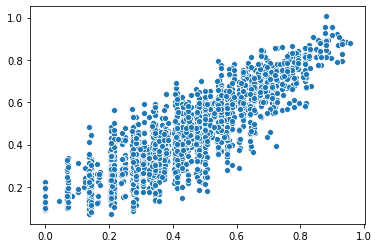

In [ ]:
# Validation predictions
sns.scatterplot(x=target, y=output)

In [ ]:
test_data = MAGraph(
    '/content/gdrive/My Drive/data/Archaea',
    [],
    '',
    [],
    lambda x: torch.zeros(1550)
)
test_dl = DataLoader(
    test_data, batch_size=20, num_workers=4, 
)

In [ ]:
output = []
target = []
with torch.no_grad():
    for batch in test_dl:
        target.append((batch.y.float()/batch.batch.unique(return_counts=True)[1]).squeeze())
        output.append(model(batch.to(device)).detach().cpu().squeeze())

output = torch.cat(output)
target = torch.cat(target)

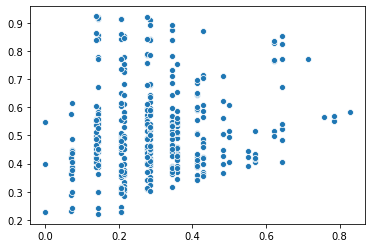

In [ ]:
# Predictions with a completely different data
sns.scatterplot(x=target, y=output)

In [ ]:
groups = torch.tensor([
[
    torch.sum(torch.sort(test_data[i].x[torch.sum(test_data[i].x, dim=1)>0], dim=0)[0] !=\
    torch.sort(test_data[j].x[torch.sum(test_data[j].x, dim=1)>0], dim=0)[0]).item()
    for i in range(len(test_data))
] for j in range(len(test_data))
])

In [ ]:
grouped_target = torch.stack([target[groups[i]==0] for i in range(372)])
grouped_output = torch.stack([output[groups[i]==0] for i in range(372)])

In [ ]:
# Correctly predicted best tree of for
torch.sum(torch.argmax(grouped_output, dim=1) == torch.argmax(grouped_target, dim=1))

tensor(116)

The result is not that bad... 

In [2]:
# Accuracy is
116/372

0.3118279569892473

Pretty promising results

!!!! THE CODE IS UNDER CONSTRUCTION !!!!